In [1]:
# February 2024
# Text classifier using logistic regression, support vector machine, and xlm-roberta
# Violeta Berdejo-Espinola and Ákos Hajas

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import pandas as pd
import os
import mpu

# read data

In [2]:
# baseline

X_train_cv = mpu.io.read('../data/X_train_cv.pickle')
X_test_cv = mpu.io.read('../data/X_test_cv.pickle')
X_train_tfidf = mpu.io.read('../data/X_train_tfidf.pickle')
X_test_tfidf = mpu.io.read('../data/X_test_tfidf.pickle')
embedding_train = mpu.io.read('../data/embedding_train.pickle')
embedding_test = mpu.io.read('../data/embedding_test.pickle')
y_train = mpu.io.read('../data/y_train.pickle')
y_test = mpu.io.read('../data/y_test.pickle')

# resampled

X_rus_train_tfidf = mpu.io.read('../data/X_rus_train_tfidf.pickle')
y_rus_train_tfidf = mpu.io.read('../data/y_rus_train_tfidf.pickle')

X_ros_train_tfidf = mpu.io.read('../data/X_ros_train_tfidf.pickle')
y_ros_train_tfidf = mpu.io.read('../data/y_ros_train_tfidf.pickle')

X_ada_train_tfidf = mpu.io.read('../data/X_ada_train_tfidf.pickle')
y_ada_train_tfidf = mpu.io.read('../data/y_ada_train_tfidf.pickle')

X_rus_train_cv = mpu.io.read('../data/X_rus_train_cv.pickle')
y_rus_train_cv = mpu.io.read('../data/y_rus_train_cv.pickle')

X_ros_train_cv = mpu.io.read('../data/X_ros_train_cv.pickle')
y_ros_train_cv = mpu.io.read('../data/y_ros_train_cv.pickle')

X_ada_train_cv = mpu.io.read('../data/X_ada_train_cv.pickle')
y_ada_train_cv = mpu.io.read('../data/y_ada_train_cv.pickle')

X_embedding_train_ros = mpu.io.read('../data/x_emb_train_ros.pickle')
y_embedding_train_ros = mpu.io.read('../data/y_emb_train_ros.pickle')

In [4]:
from collections import Counter

counter = Counter()

for x in y_test:
    counter[x] +=1
    
print(counter)

Counter({0: 991, 1: 13})


In [18]:
len(y_embedding_train_ros)

7932

In [3]:
pos = mpu.io.read('../data/pos.pickle')
neg = mpu.io.read('../data/neg_complete.pickle')

x = pos + neg
y = [1] * len(pos) + [0] * len(neg)

# model training

In [30]:
from collections import namedtuple

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# weights for class penalty (weighted cross-entropy loss)

# weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)

weight_for_class_0 = len(x) / (len(neg) * 2) 
weight_for_class_1 = len(x) / (len(pos) * 2) 

print(weight_for_class_0, weight_for_class_1)

# instantiate models

logreg = LogisticRegression(solver='lbfgs', random_state=42)
svm = SVC(kernel='linear')
logreg_weight = LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42)
svm_weight = SVC(kernel='linear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, probability=True)
mlp = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(), learning_rate='constant',
                    learning_rate_init=0.001, solver='adam', random_state=42)
mlp_tuned = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(800), learning_rate='invscaling',
                    learning_rate_init=0.001, solver='sgd', random_state=42)

# create cases

Case = namedtuple("Case", "name model X Y x y vector weighting")

cases_baseline = [
    Case(name='LR', model=logreg, X=X_train_cv, Y=y_train, x=X_test_cv, y=y_test, vector="word_frequency", weighting='None'),
    
    Case(name='SVM', model=svm, X=X_train_cv, Y=y_train, x=X_test_cv, y=y_test, vector="word_frequency", weighting='None'),
    
    Case(name='LR', model=logreg, X=X_train_tfidf, Y=y_train, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='None'),
    
    Case(name='SVM', model=svm, X=X_train_tfidf, Y=y_train, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='None'),
    
    Case(name='LR', model=logreg, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting='None'),
    
    Case(name='SVM', model=svm, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting='None'),
    
    Case(name='MLP', model=mlp, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting='None')
]

cases_weighted = [
    Case(name='LR', model=logreg_weight, X=X_train_cv, Y=y_train, x=X_test_cv, y=y_test, vector="word_frequency", weighting='BAL'),
    
    Case(name="SVM", model=svm_weight, X=X_train_cv, Y=y_train, x=X_test_cv, y=y_test, vector="word_frequency", weighting='BAL'),
    
    Case(name='LR', model=logreg_weight, X=X_train_tfidf, Y=y_train, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='BAL'),
    
    Case(name="SVM", model=svm_weight, X=X_train_tfidf, Y=y_train, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='BAL'),
    
    Case(name='LR', model=logreg_weight, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting="BAL"),
    
    Case(name='SVM', model=svm_weight, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting="BAL")
]

cases_resampled_tfidf = [
    Case(name="LR", model=logreg, X=X_rus_train_tfidf, Y=y_rus_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='RUS'),
     
    Case(name="LR", model=svm, X=X_ros_train_tfidf, Y=y_ros_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='ROS'),
    
    Case(name="LR", model=svm, X=X_ada_train_tfidf, Y=y_ada_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='ADA'),
    
    Case(name="SVM", model=svm, X=X_rus_train_tfidf, Y=y_rus_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='RUS'),
    
    Case(name="SVM", model=svm, X=X_ros_train_tfidf, Y=y_ros_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='ROS'),
    
    Case(name="SVM", model=svm, X=X_ada_train_tfidf, Y=y_ada_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='ADA')
]

cases_resampled_cv = [
    Case(name="LR", model=logreg, X=X_rus_train_cv, Y=y_rus_train_cv, x=X_test_cv, y=y_test,  vector="word_frequency", weighting='RUS'),
    
    Case(name="LR", model=logreg, X=X_ros_train_cv, Y=y_ros_train_cv, x=X_test_cv, y=y_test, vector="word_frequency", weighting='ROS'),
    
    Case(name="LR", model=logreg, X=X_ada_train_cv, Y=y_ada_train_cv, x=X_test_cv, y=y_test, vector="word_frequency", weighting='ADA'),
    
    Case(name="SVM", model=logreg, X=X_rus_train_cv, Y=y_rus_train_cv, x=X_test_cv, y=y_test,  vector="word_frequency", weighting='RUS'),   
    
    Case(name="SVM", model=logreg, X=X_ros_train_cv, Y=y_ros_train_cv, x=X_test_cv, y=y_test, vector="word_frequency", weighting='ROS'),
        
    Case(name="SVM", model=logreg, X=X_ada_train_cv, Y=y_ada_train_cv, x=X_test_cv, y=y_test, vector="word_frequency", weighting='ADA')
]

cases_resampled_embedding = [
    Case(name='LR', model=logreg, X=X_embedding_train_ros, Y=y_embedding_train_ros, x=embedding_test, y=y_test, vector='embbeding', weighting='ROS'),
    
    Case(name='MLP', model=mlp, X=X_embedding_train_ros, Y=y_embedding_train_ros, x=embedding_test, y=y_test, vector='embbeding', weighting='ROS'),
    
    Case(name='MLP-TUNED', model=mlp_tuned, X=X_embedding_train_ros, Y=y_embedding_train_ros, x=embedding_test, y=y_test, vector='embbeding', weighting='ROS')
]

0.506253782529756 40.475806451612904


In [5]:
# function to fit models, make predictions with train and test sets

from sklearn.metrics import f1_score, recall_score, precision_score

def get_scores(cases):
    # create lists to store information of each model and their prediction scores for train and test set
    scores_list = []
    models_list = []

    for case in cases:
        
        # fit models and make predictions
        model = case.model.fit(case.X, case.Y)
        
        if case.name in ['LR','SVM']:
            
            y_train_pred = cross_val_predict(case.model, case.X, case.Y, cv=StratifiedKFold(10), method='predict')
            y_test_pred = model.predict(case.x)
        
        else:
            
            y_test_pred = model.predict(case.x)
            

        # save fitted model
        models = {
            "name": f'{case.name}_{case.weighting}_{case.vector}',
            "model": model,
            
        }
        
        # save scores from predicitons
        scores = {
            'Classifier': case.name,
            'Numeric_rep': case.vector,
            'Weighting': case.weighting,
            'Instances': len(case.Y),
            'F1_tr': round(f1_score(case.Y, y_train_pred), 3),
            'F1_ts': round(f1_score(case.y, y_test_pred), 3),
            'Precision_tr': round(precision_score(case.Y, y_train_pred), 3),
            'Precision_ts': round(precision_score(case.y, y_test_pred), 3),
            'Recall_tr': round(recall_score(case.Y, y_train_pred), 3),
            'Recall_ts': round(recall_score(case.y, y_test_pred), 3)
        }
        
        # store each model's dict and prediciton scores' dict in a list
        models_list.append(models)
        scores_list.append(scores)
        
    return models_list, scores_list

In [6]:
models_resampled_cv, scores_resampled_cv = get_scores(cases_resampled_cv)
models_resampled_embedding, scores_resampled_embedding = get_scores(cases_resampled_embedding)

In [31]:
%%time

# fit models and make predictions

models_baseline, scores_baseline = get_scores(cases_baseline)
models_weighted, scores_weighted = get_scores(cases_weighted)
models_resampled_tfidf, scores_resampled_tfidf = get_scores(cases_resampled_tfidf)
models_resampled_cv, scores_resampled_cv = get_scores(cases_resampled_cv)
models_resampled_embedding, scores_resampled_embedding = get_scores(cases_resampled_embedding)

df1 = pd.DataFrame(scores_baseline)
df2 = pd.DataFrame(scores_weighted)
df3 = pd.DataFrame(scores_resampled_tfidf)
df4 = pd.DataFrame(scores_resampled_cv)
df5 = pd.DataFrame(scores_resampled_embedding)

results =  pd.concat([df1,df2,df3,df4,df5])
# results

/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/skl

CPU times: user 10min 53s, sys: 2min 55s, total: 13min 48s
Wall time: 5min 16s


,Classifier,Numeric_rep,Weighting,Instances,F1_tr,F1_ts,Precision_tr,Precision_ts,Recall_tr,Recall_ts
0,LR,word_frequency,None,4015,0.078,0.143,1.000,1.000,0.041,0.077
1,SVM,word_frequency,None,4015,0.136,0.133,0.400,0.500,0.082,0.077
2,LR,TF-IDF,None,4015,0.000,0.000,0.000,0.000,0.000,0.000
3,SVM,TF-IDF,None,4015,0.078,0.000,1.000,0.000,0.041,0.000
4,LR,embedding,None,4015,0.000,0.000,0.000,0.000,0.000,0.000
5,SVM,embedding,None,4015,0.000,0.000,0.000,0.000,0.000,0.000
6,MLP,embedding,None,4015,0.000,0.133,0.000,0.500,0.000,0.077
0,LR,word_frequency,BAL,4015,0.269,0.211,0.500,0.333,0.184,0.154
1,SVM,word_frequency,BAL,4015,0.136,0.133,0.400,0.500,0.082,0.077
2,LR,TF-IDF,BAL,4015,0.123,0.200,0.250,0.286,0.082,0.154


In [33]:
res = results.sort_values(by='Recall_ts', ascending=False).reset_index(drop=True)
# res.to_csv('../results/logreg_svm_mlp_results.csv')
res

,Classifier,Numeric_rep,Weighting,Instances,F1_tr,F1_ts,Precision_tr,Precision_ts,Recall_tr,Recall_ts
0,MLP-TUNED,embbeding,ROS,7932,0.971,0.070,0.944,0.036,1.000,0.923
1,LR,embedding,BAL,4015,0.168,0.240,0.098,0.138,0.592,0.923
2,LR,embbeding,ROS,7932,0.971,0.262,0.944,0.155,1.000,0.846
3,LR,TF-IDF,RUS,98,0.745,0.080,0.778,0.042,0.714,0.692
4,SVM,embedding,BAL,4015,0.197,0.286,0.128,0.180,0.429,0.692
5,SVM,TF-IDF,RUS,98,0.766,0.079,0.800,0.042,0.735,0.692
6,SVM,word_frequency,RUS,98,0.682,0.070,0.806,0.037,0.592,0.538
7,LR,word_frequency,RUS,98,0.682,0.070,0.806,0.037,0.592,0.538
8,MLP,embbeding,ROS,7932,0.971,0.231,0.944,0.154,1.000,0.462
9,LR,word_frequency,BAL,4015,0.269,0.211,0.500,0.333,0.184,0.154


In [29]:
# best tuning MLP

# batch_size=32 is not too bad either

mlp_tuned = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(800), learning_rate='invscaling',
                    learning_rate_init=0.001, solver='sgd', random_state=42).fit(X_embedding_train_ros, y_embedding_train_ros)

y_pred = mlp_tuned.predict(embedding_test)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)

array([[673,   1],
       [318,  12]])

# calculate loss

In [110]:
# calculate loglikelihood

# log_likelihood = y_test*np.log(y_pred) + (1-y_test)*np.log(1-y_pred)

from sklearn.metrics import log_loss

def calculate_loglikelihood(estimator):
    model = estimator.fit(embedding_train, y_train)
    y_pred = model.predict_proba(embedding_test)
    logloss = log_loss(y_test, y_pred)
    
    return logloss

def calculate_loglikelihood_ovrsmpld(estimator):
    model = estimator.fit(X_embedding_train_ros, y_embedding_train_ros)
    y_pred = model.predict_proba(embedding_test)
    logloss = log_loss(y_test, y_pred)
    
    return logloss
loss_logreg_ovrsmpld = calculate_loglikelihood(logreg)
# loss_mlp_ovrsampld = loglikelihood_loss(mlp_tuned, X_embedding_train_ros, y_embedding_train_ros, embedding_test, y_test)

print(loss_logreg_ovrsmpld)#, loss_mlp_ovrsampld)

0.053416007633002756


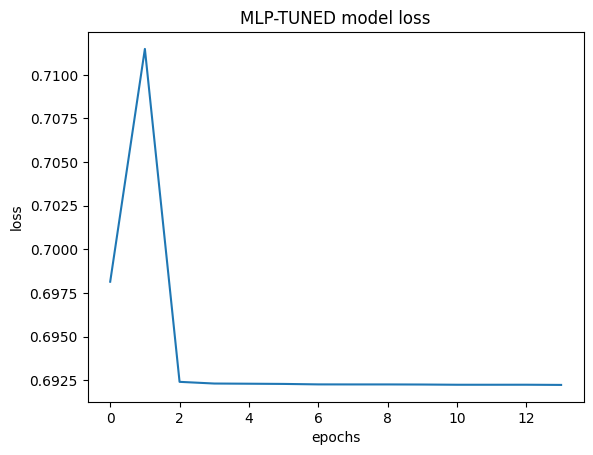

In [13]:
# calculate model loss - MLP TUNED

loss_values = mlp_tuned.loss_curve_

import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('MLP-TUNED model loss')

plt.savefig('../results/mlp-tuned_loss.png', dpi=800)

# best-performing models
# roc auc

In [104]:
# function to predict probabilities, compute auc score and roc curve 

def get_auc_roc(estimator, x_train, y_train, x_test, y_test):
    best_model = estimator.fit(x_train, y_train)
    pred_prob = best_model.predict_proba(x_test)
    y_pred = best_model.predict(x_test)
    auc_score = roc_auc_score(y_test, pred_prob[:,1])
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    
    return auc_score, fpr, tpr, y_pred

# roc curve for tpr = fpr 

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [105]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc_lr_weight, fpr_lr_weight, tpr_lr_weight, y_pred_lr_weight= get_auc_roc(logreg_weight, embedding_train, y_train, embedding_test, y_test)

auc_lr_ovsmpld, fpr_lr_ovsmpld, tpr_lr_ovsmpld, y_pred_lr_ovsmpld = get_auc_roc(logreg, X_embedding_train_ros, y_embedding_train_ros, embedding_test, y_test)

auc_svm_weight, fpr_svm_weight, tpr_svm_weight, y_pred_svm_weight = get_auc_roc(svm_weight, embedding_train, y_train, embedding_test, y_test)

auc_mlp_ovsmpld, fpr_mlp_ovsmpld, tpr_mlp_ovsmpld, y_pred_mlp_ovsmpld = get_auc_roc(mlp_tuned, X_embedding_train_ros, y_embedding_train_ros, embedding_test, y_test)

In [90]:
auc_lr_weight,auc_lr_ovsmpld,auc_svm_weight,auc_mlp_ovsmpld

(0.9571528370721105,
 0.9542808352091903,
 0.9451990995886052,
 0.8853527904991074)

/var/folders/dz/szfgpm5s0tn_frclv0gl7m2c0000gr/T/ipykernel_16222/1344933938.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


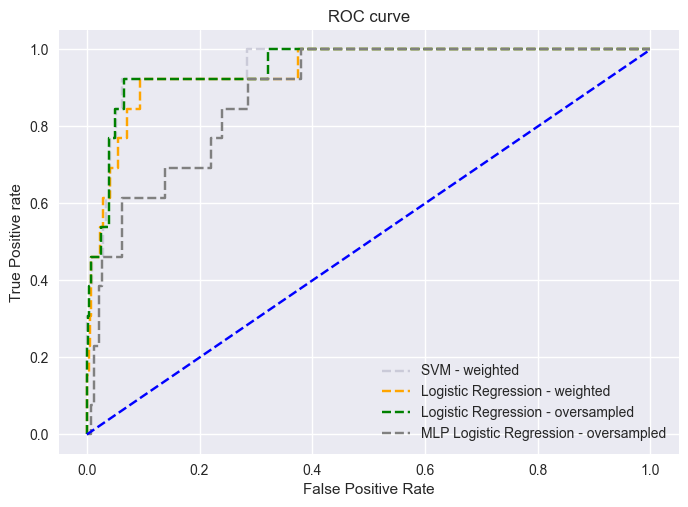

In [89]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_lr_weight, tpr_lr_weight, linestyle='--',color='#bbca', label='SVM - weighted')
plt.plot(fpr_svm_weight, tpr_svm_weight, linestyle='--',color='orange', label='Logistic Regression - weighted')
plt.plot(fpr_lr_ovsmpld, tpr_lr_ovsmpld, linestyle='--',color='green', label='Logistic Regression - oversampled')
plt.plot(fpr_mlp_ovsmpld, tpr_mlp_ovsmpld, linestyle='--',color='gray', label='MLP Logistic Regression - oversampled')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=800)
plt.show();

In [107]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_test, y_pred):
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    
    return cm

cm1 = create_confusion_matrix(y_test, y_pred_lr_weight)
cm2 = create_confusion_matrix(y_test, y_pred_svm_weight)
cm3 = create_confusion_matrix(y_test, y_pred_lr_ovr)
cm4 = create_confusion_matrix(y_test, y_pred_lr_weight)

cm = pd.concat([cm1,cm2,cm3,cm4])

# cm = pd.DataFrame({'logreg-weighted': cm1, 
#                    'svm-weighted': cm2, 
#                    'logreg-ovrsmpld': cm4,
#                    'mlp_logreg-ovrsmpld': cm3 
#                   })

# cm.to_csv('../results/logreg_svm_mlp_confusion_matrix.csv')
cm

#true negatives, false positives
#false negatives, true positives

SyntaxError: non-default argument follows default argument (1173031094.py, line 3)